In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

### Load the data

In [2]:
d = loadmat('LGN_FFdata.mat')

In [3]:
d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DTstim', 'FFspks', 'FFstim', 'FFstimR', 'FFspksR'])

In [4]:
spiks = d['FFspks'][0] # number is number of seconds from the start for that spike
stims = d['FFstim']
dt = d['DTstim'][0] # time between each stimulus
len(d['FFspksR'][0]) # data has -1s in it for each trial repeat
# Firing rate is probability of firing for a stimulus
# average rate is a rate parameter for a Poisson process

16567

In [5]:
stims # this is the intensity of the stimulus at this presentation

array([[-1.66558397],
       [ 0.125332  ],
       [ 0.28767601],
       ...,
       [-0.72446799],
       [-0.068865  ],
       [ 0.        ]])

14391


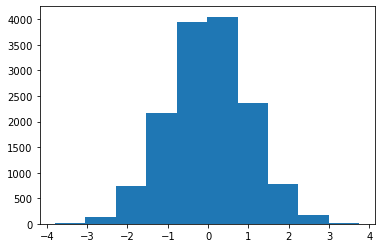

In [6]:
plt.hist(stims)
print(len(stims))

In [7]:
len(stims) * dt

array([120.00814013])

In [8]:
t = 0.02
stim_idx = math.floor(t/dt) # the stimulus trial at any time
# get multiple columns in the vector by passing in multiple indices

# we can also do some interesting matrix math to make it simpler to do


In [9]:
min(spiks), max(spiks)

(0.06999999999999318, 120.00457499999999)

### A. Calculate the average stimulus for all spike times.

In [10]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_spik = np.max(spiks) + dt
    return np.histogram(spiks, bins=np.arange(0, max_spik, dt))[0]

In [11]:
spiks_per_stim = associate_spiks_to_stims(spiks, stims)
len(stims), len(spiks_per_stim)

(14391, 14391)

In [12]:
# Whenever there is a spike,
# sum the stimulus values and divide by the number of spikes
stim_sum = 0.
stim_count = 0.
for stim_idx, spik in enumerate(spiks_per_stim):
    if spik > 0:
        stim_sum += spik * stims[stim_idx]
        # we want to multiply the stims by the number of spiks it elicited
        stim_count += spik
avg_stim_when_spiks = stim_sum / stim_count

In [13]:
avg_stim_when_spiks[0]
# should be 0.059 or so

0.05954608809527265

In [14]:
np.min(stims), np.max(stims)

(-3.7988569736480713, 3.747612953186035)

### B. Calculate and plot the full spike-triggered average of the neuron.

In [15]:
dt # the time steps between the stimulus presentations

array([0.00833911])

In [16]:
# moving window across the binned spikes, in 100ms (.1) bins
window_size = math.ceil(.1 / dt)

In [17]:
# slide the window over the stims
stas = []
for stim_idx in range(window_size, len(stims)):
    # get the average over the last <window_size> from the current stim
    stim_sum = 0.
    stim_count = 0.
    for stim, spik in zip(stims[stim_idx-window_size:stim_idx], spiks_per_stim[stim_idx-window_size:stim_idx]):
        if spik > 0:
            stim_sum += spik * stim
            stim_count += spik
    if stim_count > 0:
        avg_stim_when_spiks = (stim_sum / stim_count)[0]
    else:
        avg_stim_when_spiks = 0
    stas.append(avg_stim_when_spiks)

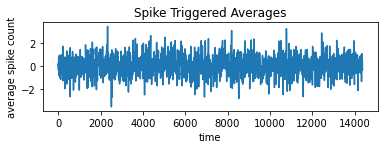

In [18]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time')
ax1.set_ylabel('average spike count')
ax1.set_title('Spike Triggered Averages')
ax1.plot(stas)

### NOTE: this is nothing

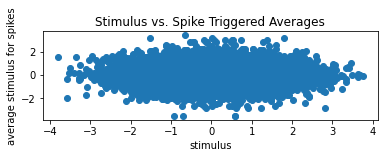

In [19]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax2 = fig.add_subplot(211)
ax2.set_xlabel('stimulus')
ax2.set_ylabel('average stimulus for spikes')
ax2.set_title('Stimulus vs. Spike Triggered Averages')
ax2.scatter(stims[window_size:], stas)

# Problem Set, done with matrices to make it simpler

## 1. Temporal receptive field of a neuron

### A. Average stimulus value for all spike times

In [20]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_spik = np.max(spiks) + dt
    return np.histogram(spiks, bins=np.arange(0, max_spik, dt))[0]

# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims)
    return np.column_stack([stims.flatten(), spiks_per_stim])

In [21]:
merged = merge_spiks_and_stims(spiks, stims)

In [22]:
merged

array([[-1.66558397,  0.        ],
       [ 0.125332  ,  0.        ],
       [ 0.28767601,  0.        ],
       ...,
       [-0.72446799,  0.        ],
       [-0.068865  ,  0.        ],
       [ 0.        ,  1.        ]])

In [23]:
# average stimulus for all spike times
np.sum(merged[:,0] * merged[:,1]) / np.sum(merged[:,1])

0.05954608809527265

### Updates

In [24]:
# S0 is stimulus at spike times
# S1 is stimulus shifted 1 time lag (dt)
# S2 is stimulus shifted 2 time lags

### B. STA of the neuron

In [25]:
# moving window across the binned spikes, in 100ms (.1) bins
w = math.ceil(.1 / dt)
w

12

In [26]:
sta = []
for i in range(w, len(stims)):
    if np.sum(merged[i-w:i,1]) > 0:
        sta.append(np.sum(merged[i-w:i,0] * merged[i-w:i,1]) / np.sum(merged[i-w:i,1]))
    else: # if there are no spikes in the window, it is 0
        sta.append(0)
sta = np.array(sta)

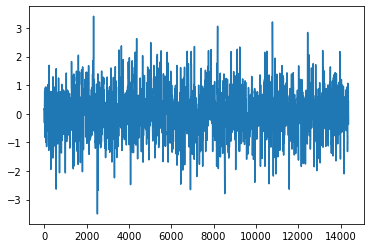

In [27]:
plt.plot(sta)

### Let's try this again

In [28]:
# moving window across the binned spikes, in 100ms (.1) bins
num_lags = math.ceil(.1 / dt)
num_lags

12

In [29]:
# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted

In [30]:
a = [1, 2, 3, 4, 5]
shift_vector(a, -3)

array([4., 5., 0., 0., 0.])

In [165]:
def learn_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta

In [166]:
sta = learn_sta(merged, num_lags=12)
len(sta), sta

(12,
 array([ 0.05954609,  0.00736425,  0.01464575,  0.29132787,  0.77145262,
        -0.77350106, -0.40184529,  0.00930294, -0.13743719,  0.01446317,
         0.0745255 ,  0.12431743]))

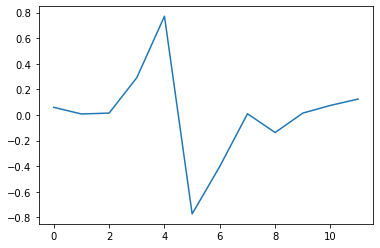

In [33]:
plt.plot(sta)

## 2. Calculating the spiking nonlinearity

### A. Calculate the stimulus convolved with the receptive field

In [38]:
# slide the STA filter over the stimulus,
# each stimulus value becomes a dot product of a length-12 sliding window and the filter

In [39]:
# it looks like if we divide the vector by its standard deviation, it has a std of 1
# TODO: figure out why this is the case
normalized_sta = sta / np.std(sta)

In [129]:
def kernel_response(stims, kernel):
    # pad the stims with zeros to be able to use the kernel from the start of the stims
    padded_stims = np.concatenate((np.zeros((len(kernel)-1)), stims), axis=None)
    
    # slide the window over the stims
    # TODO: change to the matrix method for better bookkeeping
    filtered_stims = []
    for i in range(len(kernel), len(padded_stims)+1):
        filtered_stims.append(np.dot(padded_stims[i-len(kernel):i], kernel))
    return np.array(filtered_stims)

In [130]:
# test that the kernel response does what we expect in the happy path
def test_kernel_response_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return kernel_response(test_stims, test_kernel)

test_kernel_response_happy()

array([1. , 2.5, 5. , 4. , 5. , 8. ])

In [131]:
def g_convolve(s, k):    
    g = np.convolve(s, k, mode='same')
    return g

In [132]:
# test that the g_convolve does what we expect in the happy path
def test_g_convolve_happy():
    test_kernel = np.array([0, 0.5, 1])
    test_stims = np.array([1, 2, 4, 2, 4, 6])
    
    return g_convolve(test_stims, test_kernel)

test_g_convolve_happy()

array([0.5, 2. , 4. , 5. , 4. , 7. ])

In [133]:
filtered_stims = kernel_response(stims, normalized_sta)

In [134]:
# remove negative values from the filter response
nonneg_filtered_stims = list(map(lambda x: x if x >= 0 else 0, filtered_stims))

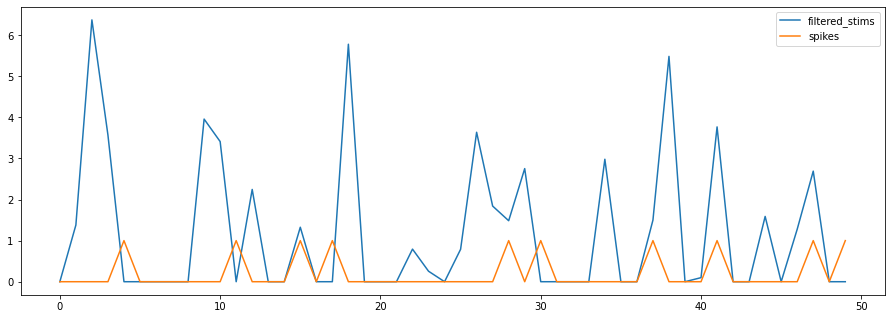

In [135]:
axt = plt.axes([1, 1, 2, 1])
#axt.plot(stims[50:100], label='stims')
#axt.plot(filtered_stims[50:100], label='filtered_stims')
axt.plot(nonneg_filtered_stims[50:100], label='filtered_stims')
axt.plot([r for s,r in merged[50:100]], label='spikes')
axt.legend()
plt.show()

### B. Calculate the histogram for the value of the filtered stimulus

In [147]:
histb = np.histogram(filtered_stims, bins=np.arange(-6, 6, 0.2))[0]

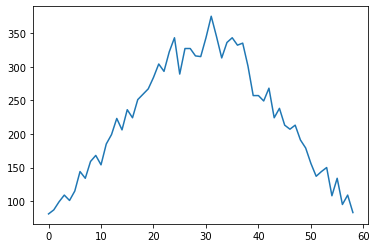

In [148]:
plt.plot(histb)

### C. Calculate the histogram for the value of the filtered stimulus for just the spike times

In [142]:
# filter the filtered_stims for just when there is a spike
indices_when_spiking = (merged[:,1] > 0).nonzero()[0]
indices_when_spiking

array([    8,    16,    23, ..., 14377, 14383, 14390])

In [155]:
filtered_stims_when_spiking = filtered_stims[indices_when_spiking]
histc = np.histogram(filtered_stims_when_spiking, bins=np.arange(-6, 6, 0.2))[0]

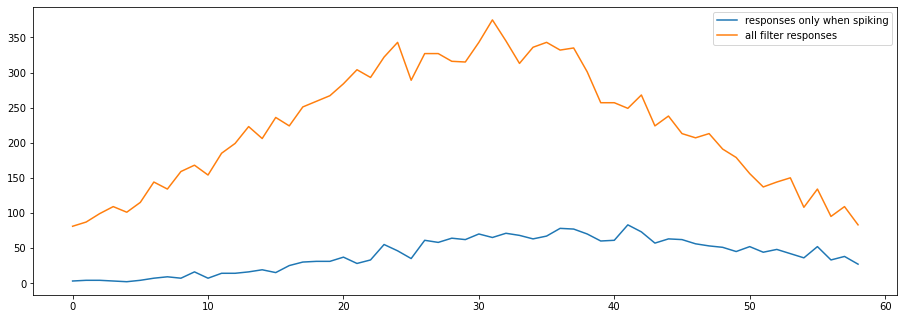

In [156]:
axc = plt.axes([1, 1, 2, 1])
axc.plot(histc, label='responses only when spiking')
axc.plot(histb, label='all filter responses')
axc.legend()
plt.show()

### D. Plot the spiking nonlinearity

In [157]:
len(histb), len(histc)

(59, 59)

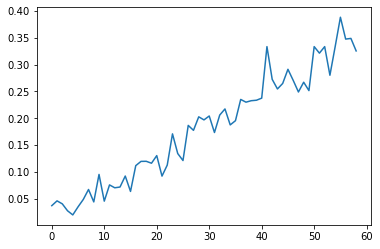

In [160]:
plt.plot(histc / histb)

## 3. Model Predictions and Cross-Validation

In [163]:
d['FFstimR']

array([[-0.36726299],
       [-1.43565404],
       [ 0.39810801],
       ...,
       [-0.14322101],
       [-1.12856805],
       [ 0.295412  ]])

In [164]:
d['FFspksR']

array([[ 0.01605,  0.01745,  0.0192 , ...,  9.95055,  9.99795, -1.     ]])

### A.

In [168]:
# calculate the neurons firing rate as a function of time, using a bin size DTstim


In [ ]:
# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
